In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install --upgrade --quiet jupyter_client ipywidgets

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
import sys
sys.path.append('../')
sys.argv=[''] 
del sys

In [4]:
cd "/root/SymmNeRF/"

/root/SymmNeRF


In [5]:
from opt import config_parser
import torch 

parser = config_parser()
args = parser.parse_args()

device = torch.device("cuda:1")
det = args.det
lindisp = args.lindisp
args.distributed = False
args.local_feature_ch = 512
args.local_rank = 1 
args.eval_scene = 'cars'
args.eval_dataset = 'srns_dataset'
args.no_load_opt = True

## Enforcing Symmetry impact.

In [6]:
from datasets import dataset_dict, create_training_dataset
from torch.utils.data import DataLoader 

from model import model_dict  
from model.sample_ray import RaySampler 
from model.render_ray import render_single_image

from utils_lab_fct import * 

import setproctitle
import torch 
import numpy as np 
import cv2
import glob 
import os
from einops import rearrange 
import matplotlib.pyplot as plt
import lpips
from skimage import metrics

# Folder directories. 
logs_folder = '/root/SymmNeRF/logs/srns_dataset/cars/'
ckpts_folder_symmnerf = os.path.join(logs_folder,'baseline/ckpts')
ckpts_folder_enforceSymm = os.path.join(logs_folder,'doubleEnforceSymm/ckpts')

# LPIPS 
lpips_vgg = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/vgg.pth


#### Define the symmetry matrix M we used. 

In [7]:
M = torch.tensor([[-1.,0.,0.],[0.,1.,0.],[0.,0.,1.]]).to(device)

#### Build up a batch. 

#### Load model weights.

In [8]:
args.enforce_symmetry = {'status': False, 'on_coarse': False,'on_fine': False,'concatenate_on_coarse':False, 'concatenate_on_fine':True}
model_ori = model_dict[args.model](args, ckpts_folder_symmnerf)

[Info] Reloading from /root/SymmNeRF/logs/srns_dataset/cars/baseline/ckpts/model_300000.pth, starting at step=300000


In [9]:
args.enforce_symmetry = {'status': True, 'on_coarse': True,'on_fine': True,'concatenate_on_coarse':False, 'concatenate_on_fine':False}
model_enforceSymm = model_dict[args.model](args,ckpts_folder_enforceSymm)

[Info] Reloading from /root/SymmNeRF/logs/srns_dataset/cars/doubleEnforceSymm/ckpts/model_300000.pth, starting at step=300000


#### Build up a data list to randomize the test set.

In [10]:
from utils_lab_fct import get_n_instance,get_an_instance_and_its_ray_sampler
bs = 1

test_dataset = dataset_dict[args.eval_dataset](args, 'test', scene=args.eval_scene)
test_loader = DataLoader(test_dataset, batch_size=bs)

data_list = get_n_instance(test_loader,n=10)

SRNsDataset:  /data/datasets/srn_cars/cars_test


In [16]:
data, ray_sampler,render_view,bs_idx = get_an_instance_and_its_ray_sampler(data_list)

model_ori.switch_to_eval()
model_enforceSymm.switch_to_eval()

with torch.no_grad():
       
        src_imgs = ray_sampler.src_img     # [B, 3, 128,128]
        tgt_imgs = ray_sampler.render_imgs # [B,NV,3,128,128]

                    
        ray_batch = ray_sampler.get_all_single_image(render_view,device)
        
        latent_vector_ori = model_ori.encode(ray_batch)
        latent_vector_enforceSymm = model_enforceSymm.encode(ray_batch)
        
        ret_ori = render_single_image(ray_sampler=ray_sampler,
                                  ray_batch=ray_batch,
                                  model=model_ori,
                                  device=device,
                                  latent_vector=latent_vector_ori,
                                  chunk_size=args.chunk_size,
                                  N_samples=args.N_samples,
                                  M = M,
                                  enforceSymm = {'status': False, 'on_coarse': False,'on_fine': False,'concatenate_on_coarse':False, 'concatenate_on_fine':True},
                                  lindisp=args.lindisp,
                                  det=True,
                                  N_importance=args.N_importance,
                                  white_bkgd=args.white_bkgd,
                                  noise=None)
        
        ret_enforceSymm = render_single_image(ray_sampler=ray_sampler,
                                  ray_batch=ray_batch,
                                  model=model_enforceSymm,
                                  device=device,
                                  latent_vector=latent_vector_enforceSymm,
                                  chunk_size=args.chunk_size,
                                  N_samples=args.N_samples,
                                  M = M,
                                  enforceSymm ={'status': True, 'on_coarse': True,'on_fine': True,'concatenate_on_coarse':False, 'concatenate_on_fine':False},
                                  lindisp=args.lindisp,
                                  det=True,
                                  N_importance=args.N_importance,
                                  white_bkgd=args.white_bkgd,
                                  noise=None)
        
        fine_pred_rgb = ret_ori['outputs_fine']['rgb'].detach()
        fine_pred_rgb_enforceSymm = ret_enforceSymm['outputs_fine']['rgb'].detach() # +ret_enforceSymm['outputs_fine_S']['rgb']).detach()/2.
        
        It_pred_original = np.clip(fine_pred_rgb.numpy(), a_min=0., a_max=1.)
        It_pred_enforceSymm = np.clip(fine_pred_rgb_enforceSymm.numpy(), a_min=0., a_max=1.)

        # Is image. 
        Is = np.clip(ray_batch['src_img'][0].permute(1, 2, 0).detach().cpu().numpy(), a_min=0, a_max=1.)
        
        # It image
        It = np.clip(ray_sampler.render_imgs[0][render_view].permute(1, 2, 0).detach().cpu().numpy(), a_min=0, a_max=1.)

psnr_original,ssim_original,lpips_original = compute_metrics(It_pred_original,It,lpips_vgg,device)
psnr_enforceSymm,ssim_enforceSymm,lpips_enforceSymm = compute_metrics(It_pred_enforceSymm,It,lpips_vgg,device)

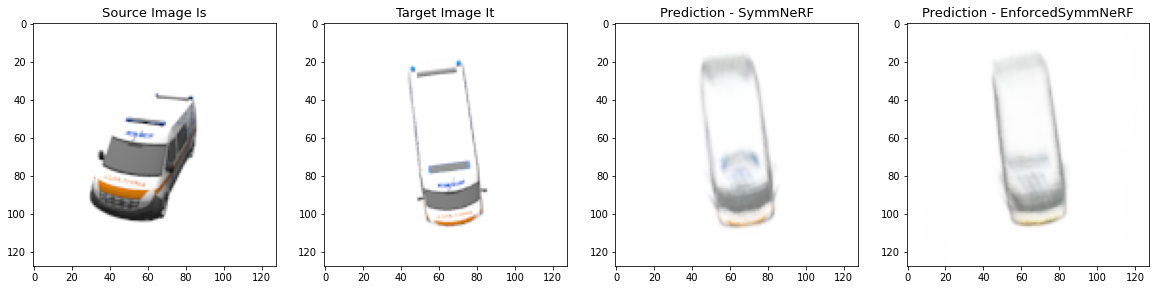


                                                psnr original: 25.49dB, psnr enforceSymm: 24.69dB
                                                ssim original: 0.899,    ssim enforceSymm: 0.892
                                                lpips original: 0.116,  lpips enforceSymm: 0.131


In [17]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20, 10))

ax1.imshow(Is)
ax2.imshow(It)
ax3.imshow(It_pred_original)
ax4.imshow(It_pred_enforceSymm)

ax1.set_title('Source Image Is', fontsize=13)
ax2.set_title('Target Image It', fontsize=13)
ax3.set_title('Prediction - SymmNeRF', fontsize=13)
ax4.set_title('Prediction - EnforcedSymmNeRF', fontsize=13)

plt.show()


print(f'''
                                                =================================================
                                                psnr original: {psnr_original}dB, psnr enforceSymm: {psnr_enforceSymm}dB
                                                ssim original: {ssim_original:.3f},    ssim enforceSymm: {ssim_enforceSymm:.3f}
                                                lpips original: {lpips_original},  lpips enforceSymm: {lpips_enforceSymm}
                                                ==================================================''')